In [1]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torchnet as tnt
from torchnet.engine import Engine
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models


from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook as tqdm
from torchsummary import summary

print(torch.__version__)
device = torch.device('cuda:0')

1.2.0


In [2]:
class Weedread(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('data'), np.uint8)
        self.target_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx]
        classes = self.target_labels[idx][1]
        family =  self.target_labels[idx][0]
        if self.transform is not None:
            images = self.transform(images)
        images = images
        
        return images, classes, family

In [3]:
INPUT_CHANNEL = 3
BATCH_SIZE = 1
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

imagenet_classes = range(1, 22)

data_path = os.path.dirname(os.getcwd()) + "/data/weed/"

Test_data = Weedread(data_path + "test.h5", transform=normalize)

Test_dataloader = DataLoader(dataset=Test_data, batch_size = BATCH_SIZE, shuffle=False)

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class ResNet_baseline(nn.Module):
    def __init__(self, num_classes = 21):
        super(ResNet_baseline, self).__init__()
        model = models.resnet18(pretrained=False)
        self.model_ft = torch.nn.Sequential(*(list(model.children())[:-1]))
        set_parameter_requires_grad(self.model_ft, False)

        self.class_fc = nn.Linear(512, num_classes)
        
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.model_ft(x)
        x = torch.flatten(x, 1)
        x_class = self.class_fc(x)
       
        return x_class

In [5]:
from torchsummary import summary
_model = ResNet_baseline(num_classes = 21)


test_images, _, _ = next(iter(Test_dataloader))
summary(_model, input_size= test_images[0].size(), device="cpu")

_model = _model.to(device)
_model.load_state_dict(torch.load('epochs/ResNet-labelsmoothing.pt'), strict=False)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

<All keys matched successfully>

In [70]:
def rel_diagram(confidence_scores, corrected, bins = 10):
    max_confidence_score = np.max(confidence_scores, axis=1)
    samples_in_bin, _, _ = plt.hist(max_confidence_score, bins=bins, range=(0, 1))
    plt.title("histogram of confidence values")
    plt.show()
    #accuracy
    h = 1./bins
    acc = np.array([np.sum(corrected[(i + h >= max_confidence_score) & (i < max_confidence_score)]) for i in np.arange(0, 1, h)])
    acc = acc / (samples_in_bin + 10e-6)
    #confidence
    conf = np.array([np.sum(max_confidence_score[(i + h >= max_confidence_score) & (i < max_confidence_score)]) for i in np.arange(0, 1, h)])
    conf = conf / (samples_in_bin + 10e-6)
    #plot diagram
    plt.bar(np.arange(bins), conf)
    plt.bar(np.arange(bins), acc)
    plt.bar(np.arange(bins), np.abs(acc - conf))
    
   
    plt.legend(["confidence" , "accuracy", "gap"])
    plt.title("Reliability diagram")
    plt.xlabel("confidence - bins")
    plt.ylabel("accuracy")
    plt.show()
    ECE = np.mean(np.abs(acc - conf))*100
    return acc, conf, ECE

(41843, 3)


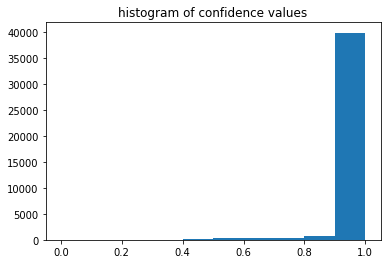

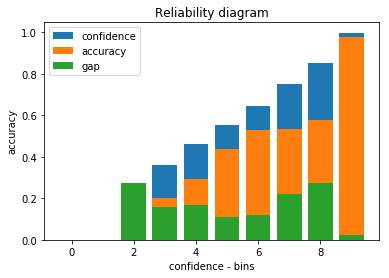

(array([0.        , 0.        , 0.        , 0.19999995, 0.29411761,
        0.43874643, 0.52987012, 0.5324074 , 0.57927786, 0.97672321]),
 array([0.        , 0.        , 0.27397484, 0.35970784, 0.4609488 ,
        0.55096464, 0.64728118, 0.75203844, 0.85371826, 0.99811935]),
 13.456107961109925)

In [71]:
log = np.load("epochs/confidence.npy")
confidence_scores = np.stack(log[:, 1], 0)
corrected = log[:, 2]
print(log.shape)
rel_diagram(confidence_scores, corrected)

(41843, 3)


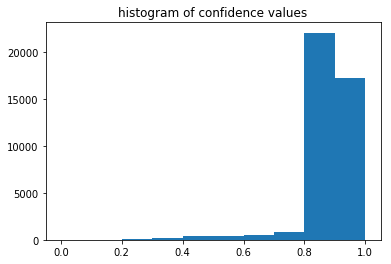

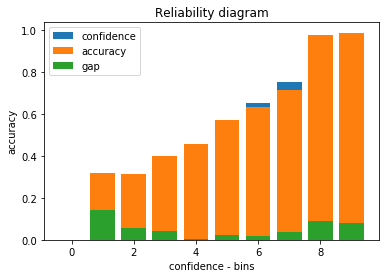

(array([0.        , 0.31999987, 0.31481479, 0.39896371, 0.45588234,
        0.57142856, 0.63257575, 0.71518986, 0.97819781, 0.9887205 ]),
 array([0.        , 0.17647845, 0.25681749, 0.35648767, 0.45382985,
        0.54860228, 0.65108142, 0.75436447, 0.8885814 , 0.90886855]),
 4.9602216380829)

In [72]:
log = np.load("epochs/confidence_smoothing.npy")
confidence_scores = np.stack(log[:, 1], 0)
corrected = log[:, 2]
print(log.shape)
rel_diagram(confidence_scores, corrected)

Temperature scaling

In [99]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:, None]

In [121]:
from IPython.display import clear_output
def LinearSearch(logits, corrected, arange = (1, 4)):
    maxECE = 100
    scaling = 0
    for T in np.arange(arange[0], arange[1], 0.2):
        confidence_scores = softmax(logits / T)
        _, _, ECE = rel_diagram(confidence_scores, corrected)
        if(ECE < maxECE):
            maxECE = ECE
            scaling = T
    return scaling

In [122]:
log = np.load("epochs/val_confidence.npy")
logits = np.stack(log[:, 0], 0)
corrected = log[:, 2]
T = LinearSearch(logits, corrected)
clear_output()

2.5999999999999996
(41843, 3)


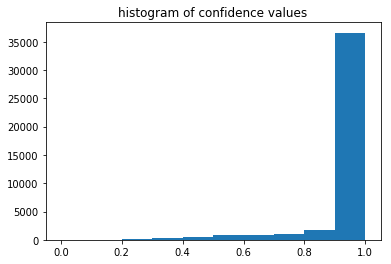

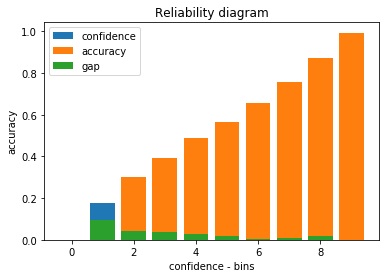

(array([0.        , 0.08333326, 0.3020833 , 0.39033456, 0.48623852,
        0.56553397, 0.65546218, 0.75827482, 0.87274909, 0.99314226]),
 array([0.        , 0.17609955, 0.26001018, 0.35331245, 0.45696522,
        0.54937462, 0.65121771, 0.75139909, 0.85632082, 0.99286382]),
 2.451210932000382)

In [124]:
log = np.load("epochs/confidence.npy")
logits = np.stack(log[:, 0], 0)
print(T)
confidence_scores = softmax(logits / T)
corrected = log[:, 2]
print(log.shape)
rel_diagram(confidence_scores, corrected)